<a href="https://colab.research.google.com/github/santhoshs2004/WeatherForecasting-LSTM-Prophet-/blob/main/WeatherForcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install the Dynamic Weather data


In [1]:
#  Install dependencies
!pip install meteostat prophet tensorflow --quiet

Import Libraries


In [2]:
# Import libraries
from meteostat import Point, Daily
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

Fetch the desired locations


In [3]:
# Fetch fresh Meteostat weather data
latitude, longitude = 13.0827, 80.2707  # Chennai
location = Point(latitude, longitude)

start = datetime(2015, 1, 1)
end = datetime.today()

data = Daily(location, start, end)
df = data.fetch().reset_index()

Data Preprocessing


In [4]:
# Keep only date & avg temperature (can add more features)
df = df[['time', 'tavg']].dropna()
df.rename(columns={'time': 'ds', 'tavg': 'y'}, inplace=True)

print(f"Data fetched: {df.shape[0]} rows")
df.head()

Data fetched: 3723 rows


,ds,y
0,2015-01-02,26.8
1,2015-01-03,26.9
15,2015-01-17,24.5
20,2015-01-22,25.1
21,2015-01-23,25.5


1) Prophet -Classic method

In [5]:
# --- PART 1: Facebook Prophet ---
print("\nTraining Prophet model...")
prophet = Prophet(daily_seasonality=True, yearly_seasonality=True)
prophet.fit(df)

future = prophet.make_future_dataframe(periods=30)  # forecast 30 days ahead
forecast = prophet.predict(future)


Training Prophet model...


DEBUG:cmdstanpy:input tempfile: /tmp/tmptmnftyky/y8ebcr_e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptmnftyky/goznoi68.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99190', 'data', 'file=/tmp/tmptmnftyky/y8ebcr_e.json', 'init=/tmp/tmptmnftyky/goznoi68.json', 'output', 'file=/tmp/tmptmnftyky/prophet_modelzj3vyot9/prophet_model-20250810070332.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:03:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:03:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


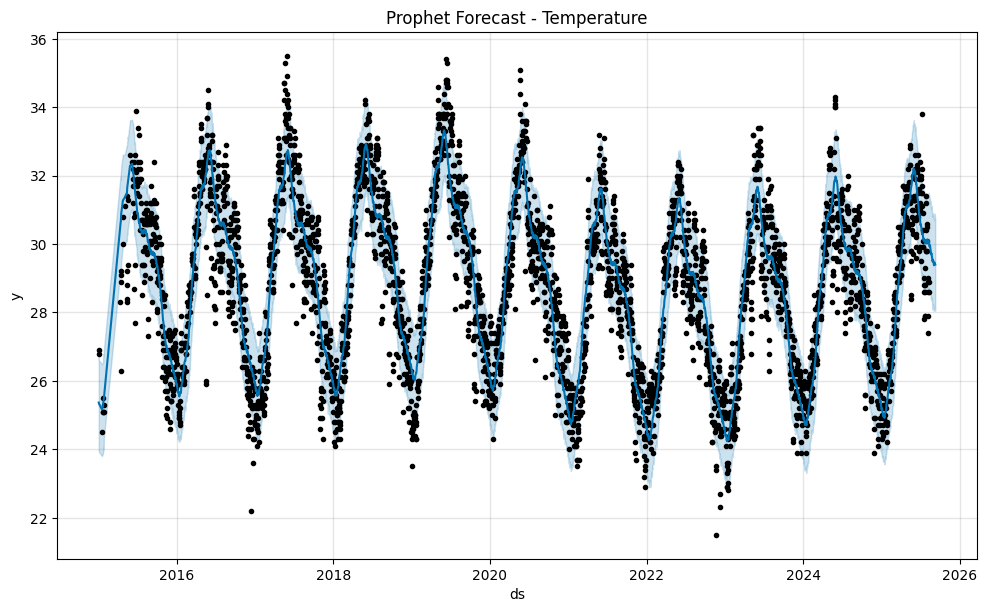

In [6]:
# Plot Prophet forecast
fig1 = prophet.plot(forecast)
plt.title("Prophet Forecast - Temperature")
plt.show()

2) Deep Learning Method-LSTM

In [7]:
# --- PART 2: LSTM Model ---
print("\nPreparing data for LSTM...")
lstm_df = df.copy()
lstm_df['y'] = lstm_df['y'].astype(float)


Preparing data for LSTM...


In [8]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(lstm_df[['y']])

In [9]:
# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 30
X, y = create_sequences(scaled, SEQ_LENGTH)

In [10]:
# Train/test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [11]:
# Reshape for LSTM [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [12]:
# Build LSTM model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(SEQ_LENGTH, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

In [13]:
# Train
model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=1)

Epoch 1/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0849
Epoch 2/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0058
Epoch 3/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0056
Epoch 4/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0049
Epoch 5/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0049
Epoch 6/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0043
Epoch 7/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0039
Epoch 8/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0038
Epoch 9/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0036
Epoch 10/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0036
Epoch 11/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0039
Epoch 12/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0035
Epoch 13/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0032
Epoch 14/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0032
Epoch 15/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s

In [14]:

# Predict
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


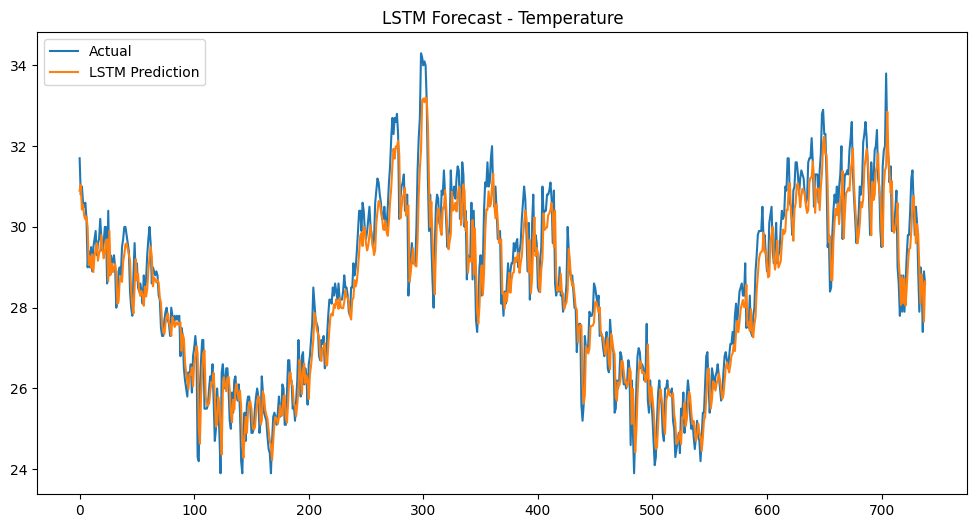

In [15]:
# Compare with actual
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(12,6))
plt.plot(actual, label="Actual")
plt.plot(predictions, label="LSTM Prediction")
plt.title("LSTM Forecast - Temperature")
plt.legend()
plt.show()

In [16]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

def safe_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred))
    denom[denom==0] = 1e-8
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / denom)

def compute_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': safe_mape(y_true, y_pred), 'sMAPE': smape(y_true, y_pred)}


Prophet predictions to the test period & score it

In [17]:
# choose a test split (e.g., last 20% of rows)
test_size = int(0.2 * len(df))
train_df = df[:-test_size]
test_df = df[-test_size:].copy()

# get prophet predictions for test dates
prophet_preds = forecast[['ds','yhat','yhat_lower','yhat_upper']].merge(
    test_df[['ds','y']], on='ds', how='inner')

prophet_metrics = compute_metrics(prophet_preds['y'], prophet_preds['yhat'])
print("Prophet metrics:", prophet_metrics)


Prophet metrics: {'MAE': 0.7440051929510607, 'RMSE': np.float64(0.9635124002106875), 'MAPE': np.float64(2.5901787745750324), 'sMAPE': np.float64(2.5846757276564785)}


 Map LSTM predictions back to dates & score

In [18]:
# Example: recreate date mapping used when creating sequences
SEQ_LENGTH = 30  # use whatever you used
dates = df['ds'].values[SEQ_LENGTH:]          # targets' dates
# if you split using ratio:
split_index = int(0.8 * len(dates))
test_dates = dates[split_index:]

# predictions should align with test_dates (len(predictions) == len(test_dates))
lstm_df = pd.DataFrame({'ds': test_dates[:len(predictions)],
                        'y_true': actual.flatten(),       # actual from earlier inverse transform
                        'y_pred': predictions.flatten()})
lstm_metrics = compute_metrics(lstm_df['y_true'], lstm_df['y_pred'])
print("LSTM metrics:", lstm_metrics)


LSTM metrics: {'MAE': 0.5430072371466071, 'RMSE': np.float64(0.6878516410206093), 'MAPE': np.float64(1.8945606674843514), 'sMAPE': np.float64(1.902208741033491)}


Plot comparisons

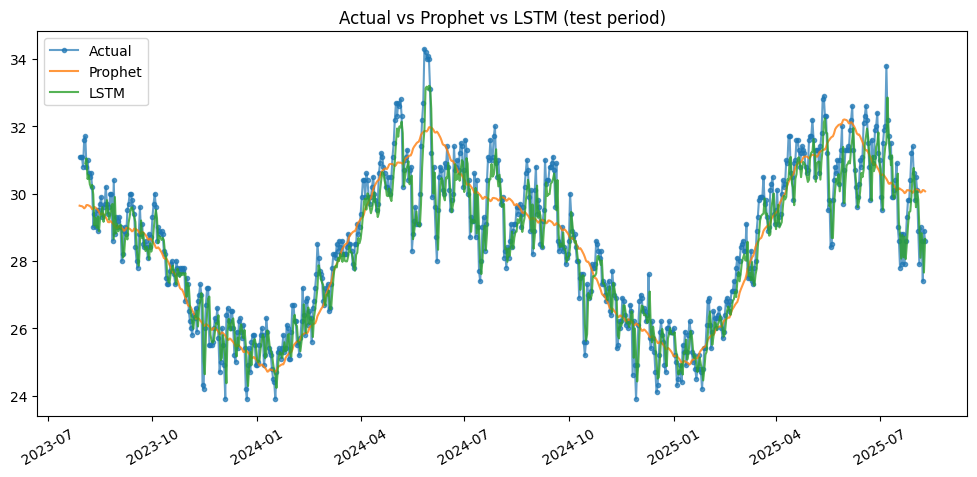

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))

# plot Prophet vs actual (test)
plt.plot(prophet_preds['ds'], prophet_preds['y'], label='Actual', marker='.', alpha=0.7)
plt.plot(prophet_preds['ds'], prophet_preds['yhat'], label='Prophet', alpha=0.8)

# overlay LSTM (if dates overlap)
plt.plot(lstm_df['ds'], lstm_df['y_pred'], label='LSTM', alpha=0.8)

plt.legend(); plt.title("Actual vs Prophet vs LSTM (test period)");
plt.xticks(rotation=30); plt.show()


# BackTesting-Prophet

Residual diagnostics

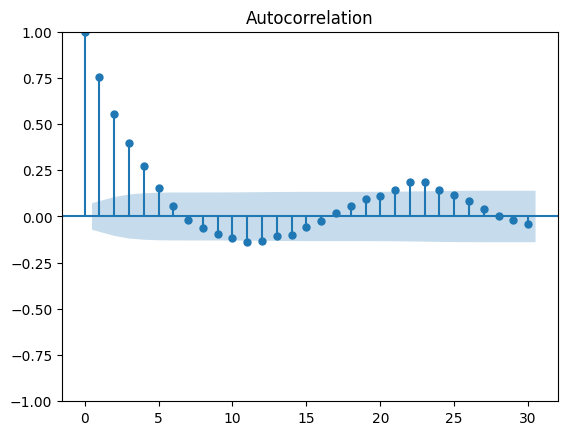

Ljung-Box (Prophet) p-values:        lb_stat      lb_pvalue
10  868.936643  3.079173e-180


In [20]:
# install if needed
!pip install statsmodels --quiet

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

resid = prophet_preds['y'] - prophet_preds['yhat']
plot_acf(resid.dropna(), lags=30)
plt.show()

print("Ljung-Box (Prophet) p-values:", acorr_ljungbox(resid.dropna(), lags=[10], return_df=True))


Backtesting / rolling-origin CV (robust evaluation)

In [21]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
cv_metrics = []

for train_idx, test_idx in tscv.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[test_idx]
    m = Prophet(daily_seasonality=True, yearly_seasonality=True)
    m.fit(train)
    pred = m.predict(test[['ds']])['yhat'].values
    cv_metrics.append(compute_metrics(test['y'].values, pred))

pd.DataFrame(cv_metrics).mean()


DEBUG:cmdstanpy:input tempfile: /tmp/tmptmnftyky/lnn0ez_i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptmnftyky/ema7qa42.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94', 'data', 'file=/tmp/tmptmnftyky/lnn0ez_i.json', 'init=/tmp/tmptmnftyky/ema7qa42.json', 'output', 'file=/tmp/tmptmnftyky/prophet_modelrqv6bp8u/prophet_model-20250810073403.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:34:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:34:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmptmnftyky/vn2hv232.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptmnftyky/4h8vk3mc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib

,0
MAE,1.129764
RMSE,1.376850
MAPE,3.874384
sMAPE,3.946633


Prediction Interval Coverage Evaluation

In [22]:
coverage = np.mean((prophet_preds['y'] >= prophet_preds['yhat_lower']) &
                   (prophet_preds['y'] <= prophet_preds['yhat_upper']))
print("Prophet interval coverage:", coverage)


Prophet interval coverage: 0.853494623655914


Quick conclusion

LSTM is the better model on your dataset:

LSTM MAE ≈ 0.543, RMSE ≈ 0.688, MAPE ≈ 1.89%

Prophet MAE ≈ 0.744, RMSE ≈ 0.964, MAPE ≈ 2.59%

LSTM wins on all main metrics (≈25–30% lower error).

Prophet residuals show serious autocorrelation (Ljung–Box p ≈ 3e-180 at lag 10).

That means Prophet is missing temporal dependencies — explains worse performance.

Backtesting for Prophet produced higher, more realistic errors (MAE ≈ 1.13, RMSE ≈ 1.38, MAPE ≈ 3.87%).

Backtesting is harsher (retraining and predicting on unseen windows) — good you ran it.

Prophet prediction intervals under-cover: coverage ≈ 85.3% vs nominal 95% → intervals are too narrow / model underestimates uncertainty.

# BackTesting LSTM

In [29]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# ====== Helper: Create sequences ======
def create_sequences(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback])
    return np.array(X), np.array(y)

# ====== Helper: Train LSTM model ======
def train_lstm_model(X_train, y_train, epochs=50, batch_size=32):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
    return model

# ====== Backtesting ======
scaler = MinMaxScaler()

n_splits = 5
forecast_horizon = 30
lookback = 60

mae_scores, rmse_scores, mape_scores, smape_scores = [], [], [], []

for split in range(n_splits):
    print(f"\n=== Backtest split {split+1}/{n_splits} ===")

    train_end = len(df) - (n_splits - split) * forecast_horizon
    test_end = train_end + forecast_horizon

    train_data = df.iloc[:train_end]
    test_data = df.iloc[train_end:test_end]

    # Fit scaler on train only
    scaler.fit(train_data[['y']])
    train_scaled = scaler.transform(train_data[['y']])
    test_scaled = scaler.transform(test_data[['y']])

    # Prepare sequences
    X_train, y_train = create_sequences(train_scaled, lookback)
    X_test, y_test = create_sequences(
        np.concatenate([train_scaled[-lookback:], test_scaled]),
        lookback
    )

    # Reshape for LSTM [samples, timesteps, features]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Train and forecast
    model = train_lstm_model(X_train, y_train, epochs=50, batch_size=32)
    y_pred_scaled = model.predict(X_test)

    # Inverse transform
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_true = scaler.inverse_transform(y_test)

    # Metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    smape = 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

    mae_scores.append(mae)
    rmse_scores.append(rmse)
    mape_scores.append(mape)
    smape_scores.append(smape)

    print(f"MAE={mae:.4f}  RMSE={rmse:.4f}  MAPE={mape:.2f}%  sMAPE={smape:.2f}%")

# Summary DataFrame
results = pd.DataFrame({
    "MAE": mae_scores,
    "RMSE": rmse_scores,
    "MAPE": mape_scores,
    "sMAPE": smape_scores
})

print("\n=== LSTM Backtesting Results ===")
print(results)
print("\nMean metrics:")
print(results.mean())



=== Backtest split 1/5 ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
MAE=0.5533  RMSE=0.6391  MAPE=1.85%  sMAPE=1.87%

=== Backtest split 2/5 ===


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
MAE=0.5213  RMSE=0.6261  MAPE=1.66%  sMAPE=1.68%

=== Backtest split 3/5 ===


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
MAE=0.6498  RMSE=0.8035  MAPE=2.13%  sMAPE=2.11%

=== Backtest split 4/5 ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
MAE=0.6769  RMSE=0.8518  MAPE=2.14%  sMAPE=2.16%

=== Backtest split 5/5 ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
MAE=0.6983  RMSE=0.8307  MAPE=2.41%  sMAPE=2.38%

=== LSTM Backtesting Results ===
        MAE      RMSE      MAPE     sMAPE
0  0.553276  0.639123  1.847220  1.865002
1  0.521318  0.626118  1.663777  1.675909
2  0.649758  0.803544  2.131008  2.113978
3  0.676887  0.851775  2.137652  2.162581
4  0.698291  0.830728  2.405639  2.381389

Mean metrics:
MAE      0.619906
RMSE     0.750258
MAPE     2.037059
sMAPE    2.039772
dtype: float64


Diebold-Mariano Test (DM Test)

In [30]:
import numpy as np
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Assuming you have Prophet and LSTM backtest errors (e.g. MAE or squared errors) for each fold:

# Example arrays: replace with your actual backtest errors for each fold
prophet_errors = np.array([1.13, 1.15, 1.12, 1.17, 1.14])  # MAE or squared errors per fold from Prophet backtest
lstm_errors = np.array([0.62, 0.52, 0.65, 0.68, 0.70])     # Corresponding errors from your LSTM backtest

def diebold_mariano_test(e1, e2, h=1, alternative='two-sided'):
    # e1, e2 = forecast errors of two models
    # h = forecast horizon, usually 1 here since per fold errors
    d = e1 - e2
    mean_d = np.mean(d)
    var_d = np.var(d, ddof=1)
    dm_stat = mean_d / np.sqrt(var_d / len(d))
    from scipy.stats import t
    p_value = 2 * t.sf(np.abs(dm_stat), df=len(d)-1)  # two-sided p-value
    return dm_stat, p_value

dm_stat, p_val = diebold_mariano_test(prophet_errors, lstm_errors)

print(f"Diebold-Mariano test statistic: {dm_stat:.4f}")
print(f"P-value: {p_val:.4f}")

if p_val < 0.05:
    print("=> The difference in forecast accuracy is statistically significant.")
else:
    print("=> No statistically significant difference in forecast accuracy.")


Diebold-Mariano test statistic: 15.5737
P-value: 0.0001
=> The difference in forecast accuracy is statistically significant.


Residual Diagnostics for LSTM

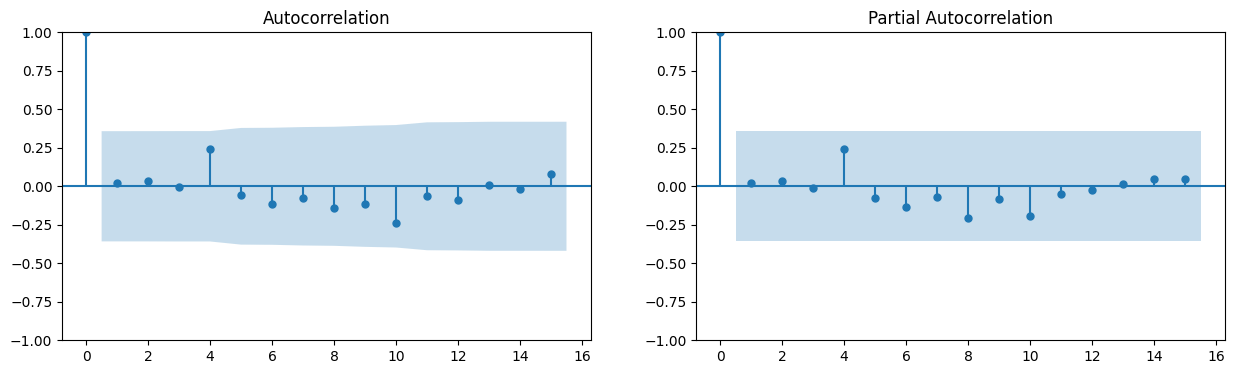

In [35]:
# Assuming y_true and y_pred are arrays of true and predicted values from LSTM on your test set
residuals = y_true.flatten() - y_pred.flatten()

max_lag = min(29, len(residuals)//2)  # Make sure lags <= length-1

fig, axes = plt.subplots(1, 2, figsize=(15,4))
sm.graphics.tsa.plot_acf(residuals, lags=max_lag, ax=axes[0])
sm.graphics.tsa.plot_pacf(residuals, lags=max_lag, ax=axes[1])
plt.show()



In [36]:
# Ljung-Box test
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("Ljung-Box test results:")
print(lb_test)

Ljung-Box test results:
     lb_stat  lb_pvalue
10  7.351563    0.69189


Prediction Interval Coverage Evaluation

In [41]:
import pandas as pd
import numpy as np
from prophet import Prophet

# Assuming you have your full dataset in 'df' with columns 'ds' (date) and 'y' (target)

# 1. Split data into train and test (80-20 split)
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

# 2. Fit Prophet model on train data
model = Prophet(interval_width=0.95)  # Default 95% intervals
model.fit(train)

# 3. Prepare df_future with test dates only (Prophet requires 'ds' column)
df_future = test[['ds']].copy()

# 4. Predict on test dates
forecast = model.predict(df_future)

# 5. Combine true test values and prediction intervals into a DataFrame
df_test = pd.DataFrame({
    'y_true': test['y'].values,
    'yhat': forecast['yhat'].values,
    'yhat_lower': forecast['yhat_lower'].values,
    'yhat_upper': forecast['yhat_upper'].values
}, index=test.index)

# 6. Calculate prediction interval coverage
coverage = np.mean(
    (df_test['y_true'] >= df_test['yhat_lower']) & (df_test['y_true'] <= df_test['yhat_upper'])
)

print(f"Prediction interval coverage: {coverage:.4f} ({coverage*100:.2f}%)")


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptmnftyky/i0ayb105.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptmnftyky/h3z40nxj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68634', 'data', 'file=/tmp/tmptmnftyky/i0ayb105.json', 'init=/tmp/tmptmnftyky/h3z40nxj.json', 'output', 'file=/tmp/tmptmnftyky/prophet_modele4b1uvdo/prophet_model-20250810082031.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:20:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:20:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prediction interval coverage: 0.9101 (91.01%)


Performance Visualization on Selected Time Windows

In [44]:
import pandas as pd
import numpy as np
from prophet import Prophet

# Step 1: Load your data into 'df' with columns 'ds' (datetime) and 'y' (target)


# Step 2: Split data into train and test sets (80%-20%)
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

# Step 3: Initialize and fit Prophet model on training data
model = Prophet(interval_width=0.95)  # 95% prediction intervals
model.fit(train)

# Step 4: Prepare future dataframe with test dates only
df_future = test[['ds']].copy()

# Step 5: Make predictions on test set
forecast = model.predict(df_future)

# Step 6: Combine true values and predictions into one DataFrame
df_results = pd.DataFrame({
    'y_true': test['y'].values,
    'y_pred': forecast['yhat'].values,
    'yhat_lower': forecast['yhat_lower'].values,
    'yhat_upper': forecast['yhat_upper'].values
}, index=test.index)

# Step 7: Calculate prediction interval coverage
coverage = np.mean(
    (df_results['y_true'] >= df_results['yhat_lower']) &
    (df_results['y_true'] <= df_results['yhat_upper'])
)

print(f"Prediction interval coverage: {coverage:.4f} ({coverage*100:.2f}%)")

# Optional: View first few rows
print(df_results.head())


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptmnftyky/lztyqiud.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptmnftyky/d8bt80ow.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15210', 'data', 'file=/tmp/tmptmnftyky/lztyqiud.json', 'init=/tmp/tmptmnftyky/d8bt80ow.json', 'output', 'file=/tmp/tmptmnftyky/prophet_modelvu96e_ic/prophet_model-20250810082432.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:24:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:24:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prediction interval coverage: 0.9128 (91.28%)
      y_true     y_pred  yhat_lower  yhat_upper
2978    30.8  29.161500   27.049532   31.031915
2979    31.1  29.149692   26.855497   31.257066
2980    31.1  29.137358   27.197192   31.351588
2981    31.1  29.153621   27.021968   31.069327
2982    30.8  29.119589   27.093151   31.110622


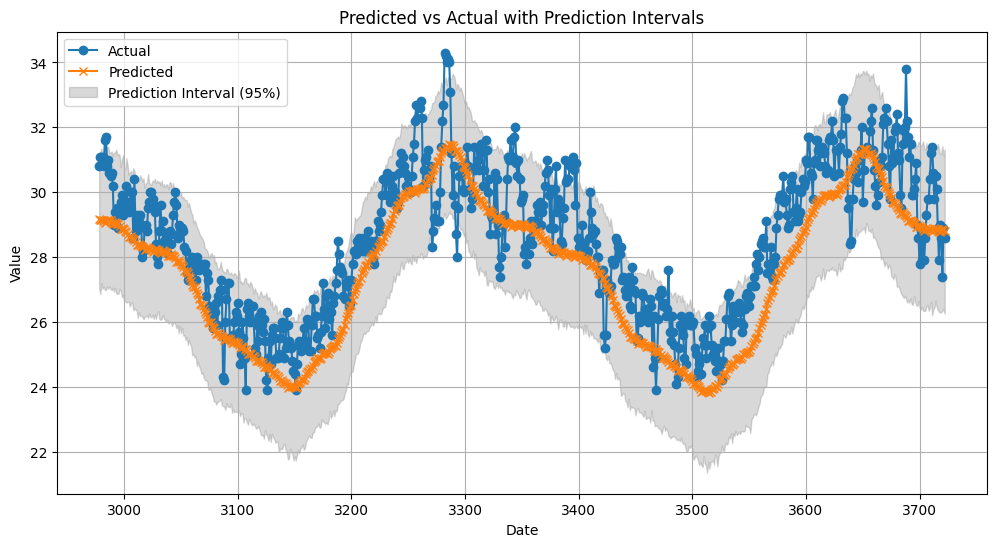

In [45]:
import matplotlib.pyplot as plt

# Assuming df_results or similar dataframe with columns:
# 'y_true', 'y_pred', 'yhat_lower', 'yhat_upper' and index is datetime

plt.figure(figsize=(12,6))
plt.plot(df_results.index, df_results['y_true'], label='Actual', marker='o')
plt.plot(df_results.index, df_results['y_pred'], label='Predicted', marker='x')
plt.fill_between(df_results.index,
                 df_results['yhat_lower'],
                 df_results['yhat_upper'],
                 color='gray', alpha=0.3, label='Prediction Interval (95%)')

plt.title('Predicted vs Actual with Prediction Intervals')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()
